In [1]:
%matplotlib inline


from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import os

from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.config import paths, params


cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [2]:
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

In [3]:
import json

CONFIG_PATH = os.path.join('cell_inference/resources/simulation_data/1000s_y1Loc2Alt_Ori2_Geo3_params/config0.json')

with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)

inference_list = config['Trial_Parameters']['inference_list']
ranges = config['Simulation_Parameters']['loc_param_range']
ranges.update(config['Simulation_Parameters']['geo_param_range'])
ranges['y'] = [-100, 100]
feature_range = (-1, 1)

print(inference_list)
print(ranges)

DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, '1000s_y1Loc2Alt_Ori2_Geo3_params')

LFP_PATH = os.path.join(TRIAL_PATH, 'summ_stats0.npz')  # LFP and labels

summ_stats   = np.load(LFP_PATH)['x']
labels = np.load(LFP_PATH)['y']

labels[:,0] = np.load(LFP_PATH)['ys']

df_la = pd.DataFrame(labels, columns=inference_list).sort_values(by='y')
# display(df_la)
df_bet_la = df_la[df_la['y'].between(-100, 100)].index.values

labels = labels[df_bet_la,:]
summ_stats = summ_stats[df_bet_la,:]
display(df_la[df_la['y'].between(-100, 100)])

['y', 'd', 'theta', 'h', 'phi', 'r_s', 'l_t', 'r_t']
{'x': [-50, 50], 'y': [-100, 100], 'z': [20.0, 200.0], 'alpha': [0, 3.141592653589793], 'h': [-1.0, 1.0], 'phi': [-3.141592653589793, 3.141592653589793], 'd': [20.0, 200.0], 'theta': [-1.0471975511965976, 1.0471975511965976], 'r_s': [7.0, 12.0], 'l_t': [20.0, 800.0], 'r_t': [0.6, 1.8], 'r_d': [0.1, 0.8], 'r_tu': [0.1, 0.8], 'l_d': [100.0, 300.0]}


,y,d,theta,h,phi,r_s,l_t,r_t
889,-99.122356,158.567656,-0.282863,-0.602610,-2.723164,9.146831,298.260572,1.082463
235,-96.539589,55.502291,-0.605595,-0.803406,2.010273,8.936617,317.455527,1.548819
215,-96.525035,177.234074,-0.398543,0.908610,0.578021,10.245818,52.762555,0.877110
502,-94.839032,52.888206,0.047551,-0.877754,-2.328690,10.672544,101.318815,1.456209
77,-93.292155,190.809861,-0.013818,-0.501318,-1.984062,11.886048,486.295251,1.207861
...,...,...,...,...,...,...,...,...
504,95.969824,181.585718,-0.649512,0.844816,2.558533,7.377579,87.041720,1.068007
269,97.727256,153.988531,0.297392,0.571833,-3.131668,11.248819,737.365449,1.403897
901,97.880291,136.032043,0.393296,0.626986,3.000355,8.189393,628.632922,1.299157
433,98.605421,103.316206,-0.322245,0.700942,2.492166,8.062453,178.569475,0.602166


In [4]:
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FullyConnectedNetwork(in_features=40, out_features=8)
PATH = 'cell_inference/resources/simulation_data/1000s_y1Loc2Alt_Ori2_Geo3_params/batch128_model.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [5]:
from cell_inference.utils.feature_extractors.SummaryStats2D import get_y_window
from tqdm.notebook import tqdm
from cell_inference.utils.spike_window import first_pk_tr, get_spike_window

DATA_PATH = 'cell_inference/resources/invivo'

INVIVO_PATH = os.path.join(DATA_PATH, 'neuronal_model_497229089_h0.7071.h5')
COORDS_PATH = os.path.join('cell_inference/resources', 'Electrode2D.h5')

with h5py.File(INVIVO_PATH, "r") as f:
    print(f.keys())
#     c = f['coord'][:]
    d = f['data'][:].reshape((-1, 384, 1))  # time x channels x samples
    print(d.shape)
#     ids = f['ID'][:]

t = np.arange(d.shape[0])

scaler = 1.  # 7720.0

filtered_lfp = np.divide(d, scaler)

pk_tr_idx_in_window = 16  # 16*0.025=0.4 ms
lfp_list = []
for i in range(d.shape[2]):
    #     filtered_lfp[i] /= np.max(np.abs(filtered_lfp[i]))
    fst_idx = first_pk_tr(filtered_lfp[:,:,i])
    start, end = get_spike_window(filtered_lfp[:,:,i], win_size=params.WINDOW_SIZE, align_at=pk_tr_idx_in_window)
    lfp_list.append(filtered_lfp[start:end, :, i])

windowed_lfp = np.stack(lfp_list, axis=0)  # (samples x time window x channels)

test_data = []
summ_stats = []
bad_indices = []
y_pos = []
for i in tqdm(range(windowed_lfp.shape[0])):
    try:
        g_lfp, g_coords, y_i = build_lfp_grid(windowed_lfp[i, :, :], params.ELECTRODE_POSITION[:, :2], y_window_size=960.0)
    except ValueError:
        # windowed_lfp = np.delete(windowed_lfp, i, axis=0)
        # self.labels = np.delete(self.labels, i, axis=0)
        bad_indices.append(i)
        continue
    test_data.append(g_lfp)
    summ_stats.append(calculate_stats(g_lfp))
    y_pos.append(y_i)
    
# ids = np.delete(ids, bad_indices, axis=0)
test_data = np.stack(test_data, axis=0)
summ_stats = np.array(summ_stats)
y_pos = np.stack(y_pos, axis=0)
print(test_data.shape, summ_stats.shape, y_pos.shape)

<KeysViewHDF5 ['data']>
(1200, 384, 1)


  0%|          | 0/1 [00:00<?, ?it/s]

(1, 176, 196) (1, 40) (1,)


In [6]:
y_pos = y_pos.reshape((-1,))
# print(y_pos)

np.set_printoptions(suppress=True)

model.eval()
model.to(device)
summ_stats = torch.Tensor(summ_stats)
summ_stats_tensor = summ_stats.to(device)
pred = model(summ_stats_tensor)
pred = pred.to("cpu").detach().numpy()

print(pred)

if True:
    for i in range(pred.shape[1]):
        old_pred = pred[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        org_pred = (((old_pred - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        pred[:,i] = org_pred

pred[:,0] = y_pos - pred[:, 0]


# idx_map = np.stack((np.arange(ids.shape[0]), ids), axis=-1)
# idx_map = dict(enumerate(ids.flatten()))
# print(ids.flatten())
# print(idx_map)
        
y_pred = pred
df = pd.DataFrame(y_pred, columns=inference_list)#.sort_values(by='y')
# df = df.rename(index=idx_map)
# df['cell_id'] = ids.flatten()
# df = df[df['y'].between(-700,700)]
display(df)

[[-0.1304245   0.82210106 -0.10256809  0.38644934 -0.9395857  -0.01430948
  -0.54312515 -0.5164161 ]]


,y,d,theta,h,phi,r_s,l_t,r_t
0,283.04245,183.989105,-0.107409,0.386449,-2.951796,9.464226,198.181183,0.89015


In [7]:
df['r_s'] = df['r_s'].clip(ranges['r_s'][0], ranges['r_s'][1])
df['l_t'] = df['l_t'].clip(ranges['l_t'][0], ranges['l_t'][1])
df['r_t'] = df['r_t'].clip(ranges['r_t'][0], ranges['r_t'][1])

In [8]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

,y,d,theta,h,phi,r_s,l_t,r_t
0,283.04245,183.989105,-0.107409,0.386449,-2.951796,9.464226,198.181183,0.89015


In [9]:
t = np.arange(test_data.shape[1])

ix = 1
ylim = [-1900,1900]
x_dist = np.unique(g_coords[:,0])
e_idx = ((g_coords[:,0]==x_dist[ix]) & 
         (g_coords[:,1]>=ylim[0]) & 
         (g_coords[:,1]<=ylim[1]))

In [10]:
from cell_inference.utils.metrics.prediction_verification import InVivoParamSimulator

simu = InVivoParamSimulator(df)
lfp, t = simu.verify_and_save(save=False)

print(lfp.shape)
data_set = []
bad_indices = []
coordinates = []
for i in tqdm(range(lfp.shape[0])):
    try:
        g_lfp, g_coords, y_i = build_lfp_grid(lfp[i, :, :], params.ELECTRODE_POSITION[:, :2], y_window_size=960.0)
    except ValueError:
        bad_indices.append(i)
        continue
    data_set.append(g_lfp)
    coordinates.append(g_coords)
data_set = np.stack(data_set, axis=0)
coordinates = np.stack(coordinates, axis=0)

test_data = np.delete(test_data, bad_indices, axis=0)
# ids = np.delete(ids, bad_indices, axis=0)
df = df.drop(index=bad_indices)

[1]
Number of invalid samples: 0 out of 1
(1, 176, 384)


  0%|          | 0/1 [00:00<?, ?it/s]

,y,d,theta,h,phi,r_s,l_t,r_t
0,283.04245,183.989105,-0.107409,0.386449,-2.951796,9.464226,198.181183,0.89015


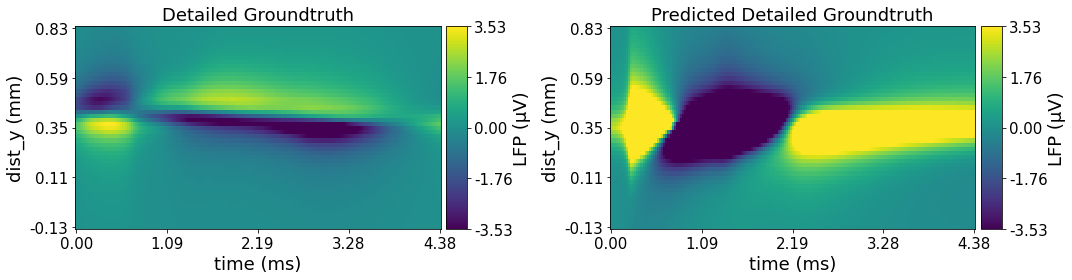

In [11]:
%matplotlib inline
from importlib import reload
import cell_inference.utils.plotting.plot_results
reload(cell_inference.utils.plotting.plot_results)
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from cell_inference.utils.plotting.plot_results import plot_multiple_lfp_heatmaps


for j, (i, row) in enumerate(df.iterrows()):
#     if i < 20:
#         continue
    fig=plt.figure(figsize=(15,4))
    outer=GridSpec(1,2)
    
#     In Vivo Plot
    vlim = plot_multiple_lfp_heatmaps(t,
                                   coordinates[j, e_idx, 1],
                                   np.transpose(test_data[j,:,e_idx]), 
#                                    savefig='lfp_heatmaps/realinvivo' + str(i) + '.jpg',
                                   vlim='auto',
                                   fontsize=18,labelpad=0,ticksize=15,nbins=5,
                                   fig=fig, outer=outer, col=0, cell_num=0, title='Detailed Groundtruth')

    # Predicted In Vivo From Params
    plot_multiple_lfp_heatmaps(t,
                                   coordinates[j, e_idx, 1],
                                   np.transpose(data_set[j,:,e_idx]), 
#                                    savefig='lfp_heatmaps/predictedinvivo' + str(i) + '.jpg',
                                   vlim=vlim,
                                   fontsize=18,labelpad=0,ticksize=15,nbins=5,
                                   fig=fig, outer=outer, col=1, cell_num=0, title='Predicted Detailed Groundtruth')

    plt.tight_layout()
    
    plt.savefig('lfp_heatmaps/' + 'detailed_groundtruth' + '.jpg')
#     if i == 22:
#         break
display(df)
plt.show()

In [12]:
df.to_pickle('invivo_df.pkl')

Max Index: 0
Min Index: 0


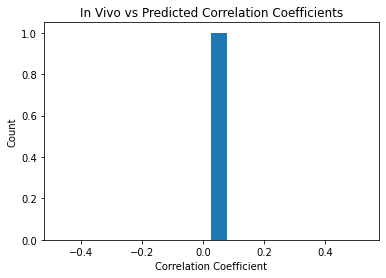

In [13]:
from cell_inference.utils.metrics.corrcoef import corrcoef

corrcoef_list = np.array([corrcoef(test_data[i,:,:], data_set[i,:,:]) for i in range(data_set.shape[0])])

maidx = np.argmax(corrcoef_list)
miidx = np.argmin(corrcoef_list)
print('Max Index: {}'.format(maidx))
print('Min Index: {}'.format(miidx))

plt.hist(corrcoef_list, bins=20)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Count')
plt.title('In Vivo vs Predicted Correlation Coefficients')
plt.show()

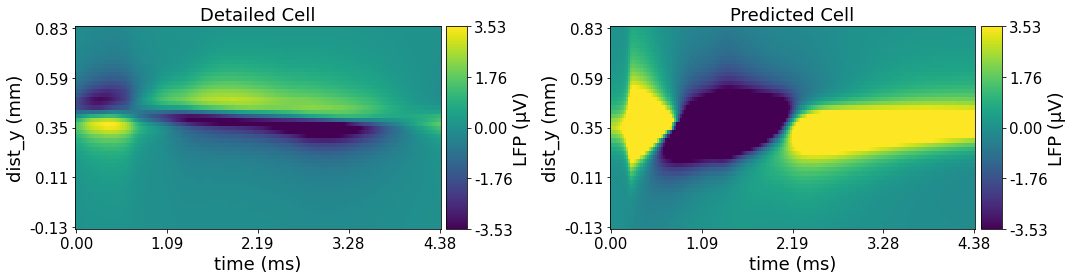

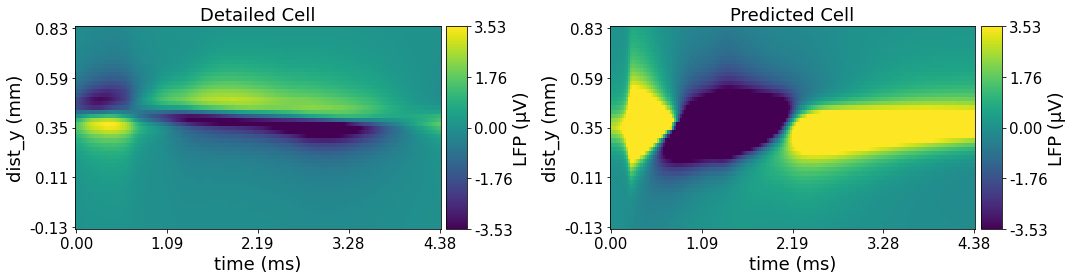

In [14]:
# fig=plt.figure(figsize=(15,10))

for i in [miidx, maidx]:
    fig=plt.figure(figsize=(15,4))
    outer=GridSpec(1,2)
#     print(df.loc[i, 'cell_id'])
#     In Vivo Plot
    vlim = plot_multiple_lfp_heatmaps(t,
                                   coordinates[i, e_idx, 1],
                                   np.transpose(test_data[i,:,e_idx]), 
#                                    savefig='lfp_heatmaps/realinvivo' + str(i) + '.jpg',
                                   vlim='auto',
                                   fontsize=18,labelpad=0,ticksize=15,nbins=5,
                                   fig=fig, outer=outer, col=0, cell_num=0, title='Detailed Cell')

    # Predicted In Vivo From Params
    plot_multiple_lfp_heatmaps(t,
                                   coordinates[i, e_idx, 1],
                                   np.transpose(data_set[i,:,e_idx]), 
#                                    savefig='lfp_heatmaps/predictedinvivo' + str(i) + '.jpg',
                                   vlim=vlim,
                                   fontsize=18,labelpad=0,ticksize=15,nbins=5,
                                   fig=fig, outer=outer, col=1, cell_num=0, title='Predicted Cell')

    plt.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


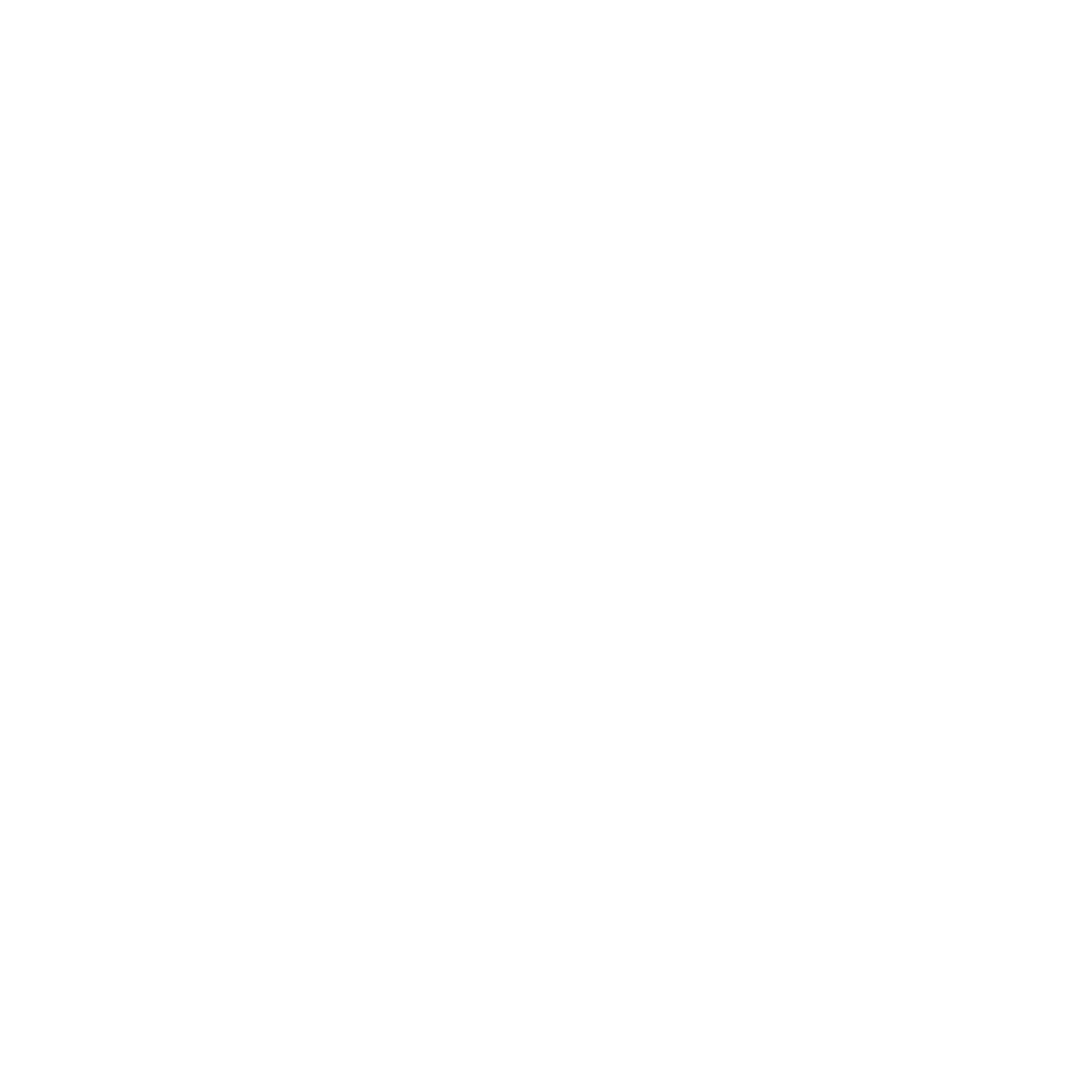

In [15]:
%matplotlib notebook

from importlib import reload
# import cell_inference.utils.plotting.plot_all_cells
# reload(cell_inference.utils.plotting.plot_all_cells)
from cell_inference.utils.plotting.plot_all_cells import plot_all_cells

fig, ax = plot_all_cells(df, figsize=(15., 15.))
ax.autoscale()

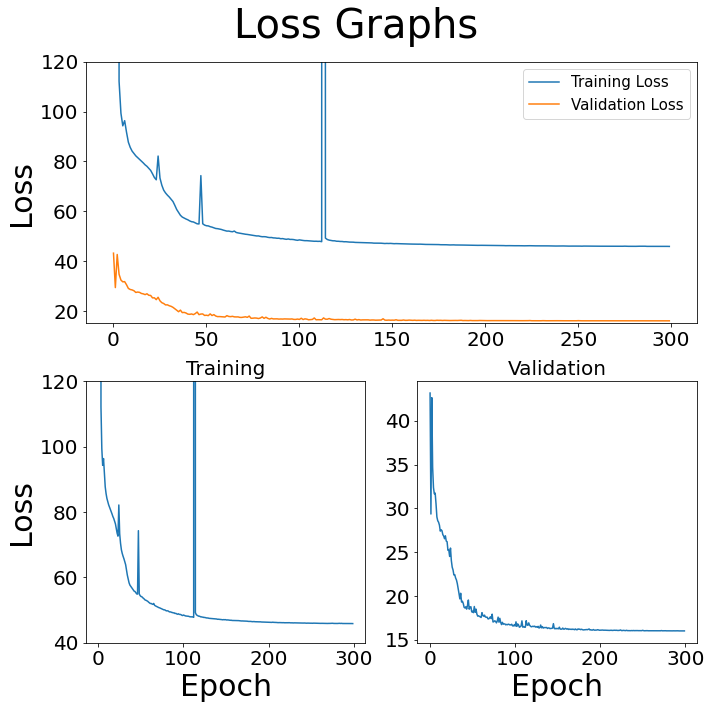

In [16]:
%matplotlib inline
import pandas as pd
from matplotlib.gridspec import GridSpec

LOSS_PATH = 'cell_inference/resources/results/pytorch_losses/13_43_39__02_14_2022.csv'
loss_df = pd.read_csv(LOSS_PATH)

t_loss = loss_df['Training_Loss'].to_numpy() # / 86729
epochs = np.arange(t_loss.shape[0])

v_loss = loss_df['Validation_Loss'].to_numpy() # / 28910


fig=plt.figure(figsize=(10,10))

fig.suptitle("Loss Graphs", fontsize=40)
gs=GridSpec(2,2)

ax1=fig.add_subplot(gs[0,:]) 
ax2=fig.add_subplot(gs[1,0]) 
ax3=fig.add_subplot(gs[1,1]) 

ax1.plot(epochs, t_loss, label='Training Loss')
ax1.plot(epochs, v_loss, label='Validation Loss')
ax1.tick_params(labelsize=20)
ax1.set_ylim(bottom=15, top=120)
# ax1.set_xlabel('Epoch', fontsize=40)
ax1.set_ylabel('Loss', fontsize=30)
ax1.legend(fontsize=15)

ax2.plot(epochs, t_loss, label='Training Loss')
ax2.tick_params(labelsize=20)
ax2.set_ylim(bottom=40, top=120)
ax2.set_xlabel('Epoch', fontsize=30)
ax2.set_ylabel('Loss', fontsize=30)
ax2.set_title('Training', fontsize=20)

ax3.plot(epochs, v_loss, label='Validation Loss')
ax3.tick_params(labelsize=20)
ax3.set_xlabel('Epoch', fontsize=30)
ax3.set_title('Validation', fontsize=20)
# ax3.set_ylabel('Loss', fontsize=40)

plt.tight_layout()
plt.show()
# print(t_loss)
# display(loss_df)